In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2

In [2]:
IMAGE_FOLDER = "Dataset/images/" 
meta_Dataframe = pd.read_csv("Dataset/info.csv")

In [3]:
print(meta_Dataframe.head())

             Namefile  Species   bbxmin   bbymin   bbxmax   bbymax
0    Abyssinian_1.jpg      cat      333       72      425      158
1   Abyssinian_10.jpg      cat       72      105      288      291
2  Abyssinian_100.jpg      cat      151       71      335      267
3  Abyssinian_101.jpg      cat       54       36      319      235
4  Abyssinian_102.jpg      cat       23       27      325      320


In [4]:
img_name = meta_Dataframe.iloc[0,0]

In [5]:
print(img_name)
print(type(img_name))

Abyssinian_1.jpg
<class 'str'>


In [6]:
def getinfo(meta_Dataframe, imgind):
    return meta_Dataframe.iloc[imgind, 0], meta_Dataframe.iloc[imgind, 1], (meta_Dataframe.iloc[imgind, 2],meta_Dataframe.iloc[imgind, 3],meta_Dataframe.iloc[imgind, 4],meta_Dataframe.iloc[imgind, 5])

def show_bndbox(namefile, label, bndboxinfo, color = (0,255,0)):
    image = cv2.imread(namefile)
    left = bndboxinfo[0]
    top = bndboxinfo[1]
    right = bndboxinfo[2]
    bottom = bndboxinfo[3]
    imgHeight, imgWidth, _ = image.shape
    thick = int((imgHeight + imgWidth) // 900)
    
    cv2.rectangle(image,(left, top), (right, bottom), color, thick)
    cv2.putText(image, label, (left, top - 12), 0, 1e-3 * imgHeight, color, thick//3)
    
    plt.axis("off")
    plt.title(namefile)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

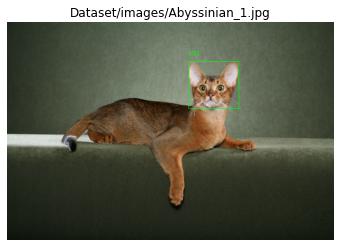

In [7]:
filename, label, bndboxinfo = getinfo(meta_Dataframe, 0)
path_file=IMAGE_FOLDER + filename

show_bndbox(path_file, label, bndboxinfo)

In [8]:
def 

SyntaxError: invalid syntax (<ipython-input-8-455680ca2399>, line 1)